# GAN

The real samples has three types of features: 
- non sequential features which has a shape of (14, )
- sequential features which has a shape of (60,17)
- image features(MTF along the features) which has a shape of (31,31,1). 

There are three corresponding input layers in the discriminators which were then followed by Dense layers, LSTM layers or CNN layers and merged together. After that there are several dense layers for classification. 


Correspondingly, we have three generators to generate fake samples from noise. 


## Import data

In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten,concatenate,LSTM,Input,Bidirectional
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,Input, Dense, Reshape, Flatten, Embedding, Dropout,Conv2DTranspose
from keras import backend as K
from keras import initializers
from keras.utils import to_categorical
from keras import backend as K
from keras import regularizers
from keras import metrics


with open('/home/yz3698/label.json') as f:
    labels=json.load(f)
with open('/home/yz3698/non_sequential_features.json') as f:
    non_sequential_features=json.load(f)
with open('/home/yz3698/padded_sequential_features_3.json') as f:
    sequential_features=json.load(f)
with open('featurematrix.json') as f:
    arr_=json.load(f)
arr_=np.array(arr_)

# from dict to numpy array
feature1=np.array([sequential_features[key] for key in sequential_features.keys()])
feature2=np.array([non_sequential_features[key] for key in non_sequential_features.keys()])
label=np.array([labels[key] for key in labels.keys()])

#reshape features
arr_=arr_.reshape(-1,31,31,1)
feature1=feature1[:,:,1:]


Using TensorFlow backend.


## Preprocessing
- We separate data into training set, validation set, and testing set.
- We will only use benign samples to train the model

In [2]:
#training set include only benign users
arr_benign=arr_[label==0]
arr_fraud=arr_[label==1]

feature1_benign=feature1[label==0]
feature1_fraud=feature1[label==1]

feature2_benign=feature2[label==0]
feature2_fraud=feature2[label==1]

label_benign=label[label==0]  
label_fraud=label[label==1]  

from sklearn.model_selection import train_test_split

X_train_arr, X_test_arr,X_train_f1, X_test_f1,X_train_f2, X_test_f2,y_train,y_test= train_test_split(arr_benign,
                                                                                                     feature1_benign,
                                                                                                     feature2_benign,
                                                                                                     label_benign,
                                                                                          test_size=0.40, random_state=42)
# testing set includes both benign and fraud 
X_test_arr=np.concatenate([X_test_arr, arr_fraud])
X_test_f1=np.concatenate([X_test_f1, feature1_fraud])
X_test_f2=np.concatenate([X_test_f2, feature2_fraud])
y_test=np.concatenate([y_test, label_fraud])


#shuffle testing set
randomize = np.arange(len(X_test_arr))
np.random.shuffle(randomize)
X_test_arr = X_test_arr[randomize]
X_test_f1 = X_test_f1[randomize]
X_test_f2 = X_test_f2[randomize]
y_test = y_test[randomize]

In [3]:
X_train_arr.shape,X_train_f1.shape,X_train_f2.shape,y_train.shape

((83878, 31, 31, 1), (83878, 60, 17), (83878, 14), (83878,))

In [3]:
# validation set for model selection, testing set for reporting 
X_valid_arr,X_test_arr,X_valid_f1,X_test_f1,X_valid_f2,X_test_f2,y_valid,y_test=train_test_split(X_test_arr,
                                                                                                 X_test_f1,
                                                                                                 X_test_f2,
                                                                                                 y_test,
                                                                                                 test_size=0.50, random_state=42)

In [8]:
X_valid_arr.shape

(33022, 31, 31, 1)

## build multi-source GANs

In [4]:
class GAN():
    def __init__(self):
        self.feature_matrix_shape=(31,31,1)
        self.mtf_shape=(60,60,1)
        self.lstm_features_cnt=17
        self.non_seq_shape=(14,)
        optimizer_SGD= SGD()
        optimizer_adam= Adam()

        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',optimizer=optimizer_SGD, metrics=['accuracy'])
        
        # Build the generator
        self.generator1 = self.build_generator1()
        noise_non_sequential=Input(shape=(14,),name="dense_input")
        non_sequential_fake=self.generator1(noise_non_sequential)
        
        self.generator2 = self.build_generator2()
        noise_fm=Input(shape=(32,32,1),name="cnn_input")
        fm_fake=self.generator2(noise_fm)
        
        self.generator3 = self.build_generator3()
        noise_rnn=Input(shape=(60,17),name="rnn_input")
        rnn_fake=self.generator3(noise_rnn)

        # combined generator and discriminator for generator training
        self.discriminator.trainable = False  #discriminator is not trainable when training generator
        validity = self.discriminator([non_sequential_fake,fm_fake,rnn_fake])
        self.combined = Model([noise_non_sequential,noise_fm,noise_rnn], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_adam)
        
            

    def build_discriminator(self):
        ## input from feature matrix
        input_fm=Input(shape=self.feature_matrix_shape,name="cnn_input")
        fm=BatchNormalization()(input_fm)
        cnn1=Conv2D(64, (3, 3), padding="same")(fm)
        cnn1=LeakyReLU(alpha=0.2)(cnn1)
        bn1=BatchNormalization()(cnn1)
        bn1=Dropout(0.3)(bn1)
        pool1=AveragePooling2D(pool_size=(2,2),strides=2)(bn1)
        cnn2=Conv2D(32, (3, 3), padding="same")(pool1)
        cnn2=LeakyReLU(alpha=0.2)(cnn2)
        bn2=BatchNormalization()(cnn2)
        pool2=AveragePooling2D(pool_size=(2,2),strides=2)(bn2)
        pool2=Dropout(0.3)(pool2)
        cnn3=Conv2D(1, (3, 3), padding="same")(pool2)
        cnn3=LeakyReLU(alpha=0.2)(cnn3)
        fm_output=Flatten()(cnn3)


        #input from sequential features
        input_rnn=Input(shape=(60,17),name="rnn_input")
        lstm1=Bidirectional(keras.layers.LSTM(64, activation='tanh', return_sequences=True))(input_rnn)
        #lstm1=SeqSelfAttention(attention_activation='sigmoid')(lstm1)
        lstm1=Dropout(0.3)(lstm1)
        rnn_output=Bidirectional(keras.layers.LSTM(32, activation='tanh', return_sequences=False))(lstm1)
        

        #input from non-sequential features
        input_non_sequential=Input(shape=self.non_seq_shape,name="dense_input")
        dense1=Dense(32)(input_non_sequential)
        dense1=LeakyReLU(alpha=0.2)(dense1)
        bn3=BatchNormalization()(dense1)
        drop2=Dropout(0.3)(bn3)
        dense2_output=Dense(32)(drop2)
        dense2_output=LeakyReLU(alpha=0.2)(dense2_output)

        
        #combine three types of input
        merged = concatenate([dense2_output,fm_output, rnn_output])
        dense3=Dense(128)(merged)
        dense3=LeakyReLU(alpha=0.2)(dense3)
        bn4=BatchNormalization()(dense3)
        bn4=Dropout(0.3)(bn4)
        dense4=Dense(64)(bn4)
        dense4=LeakyReLU(alpha=0.2)(dense4)
        bn5=BatchNormalization()(dense4)
        out = Dense(1, activation='sigmoid', name='output_layer')(bn5)

        model = Model(inputs=[input_non_sequential,input_fm,input_rnn], outputs=[out])
        #model.summary()
        return model
    
    def build_generator1(self):
        # generator to generate fake data like non-sequential features 
        model = Sequential()

        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.25))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(14,activation='tanh'))

        #model.summary()

        noise = Input(shape=(14,))
        img = model(noise)

        return Model(noise, img)
    
    def build_generator2(self):
         # generator to generate fake data like feature matrix
        model = Sequential()

        model.add(Conv2DTranspose(8,strides=(2, 2), kernel_size=(3,3)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(Dropout(0.25))
        model.add(Conv2D(filters=4,kernel_size=4,strides=2,padding='valid'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(Conv2D(filters=1,kernel_size=4,strides=1,padding='same',activation='tanh'))
        noise = Input(shape=(32,32,1))
        img = model(noise)
        #model.summary()
        return Model(noise, img)
    
    def build_generator3(self):
        # generator to generate fake data like sequential features
        model = Sequential()
        model.add(keras.layers.LSTM(32, activation="tanh", return_sequences=True))
        model.add(Dropout(0.25))
        model.add(keras.layers.LSTM(64, activation="tanh", return_sequences=True))
        model.add(Dropout(0.25))
        model.add(keras.layers.LSTM(128, activation="tanh", return_sequences=True))
        model.add(Dropout(0.25))
        model.add(keras.layers.LSTM(17, activation="tanh",return_sequences=True))
        noise = Input(shape=(60,17))
        img = model(noise)
       # model.summary()
        return Model(noise, img)
    

    def train(self,X_train_arr,X_train_f1,X_train_f2,y_train,X_test_arr,X_test_f1,X_test_f2,y_test,
              epochs=200, batch_size=128):
        auc_list=[]
        ks_list=[]
        auc_progress = []
        half_batch = int(batch_size / 2)

        noise_until = epochs


        for epoch in range(epochs):
            # Select a random half batch of real benign users data
            idx = np.random.randint(0, y_train.shape[0], half_batch)
            arr=X_train_arr[idx]
            sequential=X_train_f1[idx]
            non_sequential=X_train_f2[idx]

           # Sample noise and generate a half batch of new fake data
            noise1 = np.random.normal(0, 1, (half_batch, 14))
            noise2 = np.random.normal(0, 1, (half_batch, 32,32,1))
            noise3 = np.random.normal(0, 1, (half_batch, 60,17))
                
            non_sequential_fake=self.generator1.predict(noise1)
            fm_fake=self.generator2.predict(noise2)
            rnn_fake=self.generator3.predict(noise3)

            valid = np.ones((half_batch, 1))
            fake = np.zeros((half_batch, 1))

            # Train the discriminator
            
            d_loss_real = self.discriminator.train_on_batch([non_sequential,arr,sequential], valid)
            d_loss_fake = self.discriminator.train_on_batch([non_sequential_fake,fm_fake,rnn_fake], fake)

 
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)



            #  Train Generator
  
            noise1 = np.random.normal(0, 1, (batch_size, 14))
            noise2 = np.random.normal(0, 1, (batch_size, 32,32,1))
            noise3 = np.random.normal(0, 1, (batch_size, 60,17))
                
            validity = np.ones((batch_size, 1))

           # if epoch<=1000 or epoch%3==0:
            g_loss = self.combined.train_on_batch([noise1,noise2,noise3], validity)
           
            #g_loss = self.combined.test_on_batch([noise1,noise2,noise3], validity)

            # Plot the progress
            if epoch % 5 == 0:
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % 50 == 0:
                y_pred = self.discriminator.predict([X_test_f2,X_valid_arr,X_test_f1],batch_size=batch_size)
                (fpr, tpr, thresholds) = roc_curve(y_test,y_pred)
                area = auc(fpr,tpr)
                auc_list.append(area)

                ks=(tpr-fpr)
                max_ks=np.max(ks)
                ks_list.append(max_ks)
                print('Epoch: {}, auc: {:.5f}, ks: {}'.format(epoch,area,max_ks))
                self.discriminator.save("/home/yz3698/gans_model_saved/"+str(epoch)+"_model_gans.h5")


        return auc_list,ks_list


In [5]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [6]:
if __name__ == '__main__':
    gan = GAN()
    auc_list,ks_list=gan.train(X_train_arr,X_train_f1,X_train_f2,y_train,X_valid_arr,X_valid_f1,X_valid_f2,y_valid,
             epochs=10000, 
             batch_size=512)

/home/yz3698/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/yz3698/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.909577, acc: 48.83%] [G loss: 0.912915]
Epoch: 0, auc: 0.48100, ks: 7.141581860381496e-05


/home/yz3698/.local/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
/home/yz3698/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5 [D loss: 0.860117, acc: 48.83%] [G loss: 0.868136]
10 [D loss: 0.848213, acc: 48.63%] [G loss: 0.838002]
15 [D loss: 0.816462, acc: 50.20%] [G loss: 0.805718]
20 [D loss: 0.809749, acc: 50.78%] [G loss: 0.807006]
25 [D loss: 0.807147, acc: 49.22%] [G loss: 0.796257]
30 [D loss: 0.793322, acc: 50.00%] [G loss: 0.797292]
35 [D loss: 0.787203, acc: 50.20%] [G loss: 0.791473]
40 [D loss: 0.780677, acc: 51.56%] [G loss: 0.771913]
45 [D loss: 0.788931, acc: 51.37%] [G loss: 0.777997]
50 [D loss: 0.776365, acc: 46.88%] [G loss: 0.780361]
Epoch: 50, auc: 0.51845, ks: 0.031289509258949855
55 [D loss: 0.775696, acc: 51.37%] [G loss: 0.768522]
60 [D loss: 0.769747, acc: 48.83%] [G loss: 0.767423]
65 [D loss: 0.762148, acc: 53.12%] [G loss: 0.766120]
70 [D loss: 0.758430, acc: 51.95%] [G loss: 0.764964]
75 [D loss: 0.755272, acc: 50.00%] [G loss: 0.758107]
80 [D loss: 0.753541, acc: 46.48%] [G loss: 0.756498]
85 [D loss: 0.753806, acc: 50.78%] [G loss: 0.752269]
90 [D loss: 0.745001, acc: 51.37%

695 [D loss: 0.701787, acc: 49.22%] [G loss: 0.701110]
700 [D loss: 0.701649, acc: 48.83%] [G loss: 0.701648]
Epoch: 700, auc: 0.52970, ks: 0.04034501228228948
705 [D loss: 0.701531, acc: 49.02%] [G loss: 0.701755]
710 [D loss: 0.700906, acc: 49.22%] [G loss: 0.701574]
715 [D loss: 0.700632, acc: 50.20%] [G loss: 0.701361]
720 [D loss: 0.701633, acc: 48.05%] [G loss: 0.701533]
725 [D loss: 0.701770, acc: 50.59%] [G loss: 0.700700]
730 [D loss: 0.702211, acc: 47.66%] [G loss: 0.701680]
735 [D loss: 0.700998, acc: 49.41%] [G loss: 0.701270]
740 [D loss: 0.700160, acc: 49.02%] [G loss: 0.701492]
745 [D loss: 0.701374, acc: 51.37%] [G loss: 0.700605]
750 [D loss: 0.700964, acc: 51.76%] [G loss: 0.700848]
Epoch: 750, auc: 0.53035, ks: 0.041982771876815095
755 [D loss: 0.700612, acc: 48.24%] [G loss: 0.700624]
760 [D loss: 0.700901, acc: 48.44%] [G loss: 0.701299]
765 [D loss: 0.701165, acc: 50.59%] [G loss: 0.700351]
770 [D loss: 0.701104, acc: 48.63%] [G loss: 0.699798]
775 [D loss: 0.7013

1370 [D loss: 0.697039, acc: 47.85%] [G loss: 0.696783]
1375 [D loss: 0.696783, acc: 49.41%] [G loss: 0.697133]
1380 [D loss: 0.697330, acc: 50.78%] [G loss: 0.697107]
1385 [D loss: 0.697230, acc: 49.80%] [G loss: 0.696824]
1390 [D loss: 0.697008, acc: 49.61%] [G loss: 0.696645]
1395 [D loss: 0.697264, acc: 51.17%] [G loss: 0.696589]
1400 [D loss: 0.696843, acc: 51.17%] [G loss: 0.696676]
Epoch: 1400, auc: 0.53110, ks: 0.04844742658037127
1405 [D loss: 0.696847, acc: 49.41%] [G loss: 0.696731]
1410 [D loss: 0.696776, acc: 46.68%] [G loss: 0.696567]
1415 [D loss: 0.696694, acc: 47.66%] [G loss: 0.696811]
1420 [D loss: 0.696974, acc: 49.61%] [G loss: 0.696596]
1425 [D loss: 0.696863, acc: 50.59%] [G loss: 0.696738]
1430 [D loss: 0.696729, acc: 49.41%] [G loss: 0.696661]
1435 [D loss: 0.696982, acc: 48.05%] [G loss: 0.696628]
1440 [D loss: 0.697191, acc: 46.88%] [G loss: 0.696738]
1445 [D loss: 0.696788, acc: 46.48%] [G loss: 0.696349]
1450 [D loss: 0.696632, acc: 52.73%] [G loss: 0.69658

2045 [D loss: 0.695418, acc: 48.83%] [G loss: 0.695545]
2050 [D loss: 0.695648, acc: 47.27%] [G loss: 0.695444]
Epoch: 2050, auc: 0.53145, ks: 0.05028080744002805
2055 [D loss: 0.695520, acc: 48.05%] [G loss: 0.695538]
2060 [D loss: 0.695668, acc: 50.98%] [G loss: 0.695375]
2065 [D loss: 0.695486, acc: 47.27%] [G loss: 0.695510]
2070 [D loss: 0.695569, acc: 51.56%] [G loss: 0.695402]
2075 [D loss: 0.695391, acc: 47.66%] [G loss: 0.695439]
2080 [D loss: 0.695578, acc: 48.63%] [G loss: 0.695374]
2085 [D loss: 0.695433, acc: 48.05%] [G loss: 0.695490]
2090 [D loss: 0.695495, acc: 48.24%] [G loss: 0.695309]
2095 [D loss: 0.695513, acc: 49.61%] [G loss: 0.695449]
2100 [D loss: 0.695444, acc: 49.80%] [G loss: 0.695449]
Epoch: 2100, auc: 0.53085, ks: 0.05070834150497838
2105 [D loss: 0.695577, acc: 51.56%] [G loss: 0.695377]
2110 [D loss: 0.695560, acc: 48.44%] [G loss: 0.695384]
2115 [D loss: 0.695465, acc: 48.63%] [G loss: 0.695458]
2120 [D loss: 0.695400, acc: 48.05%] [G loss: 0.695256]
21

2715 [D loss: 0.694974, acc: 47.27%] [G loss: 0.694932]
2720 [D loss: 0.694947, acc: 48.05%] [G loss: 0.694909]
2725 [D loss: 0.695014, acc: 46.09%] [G loss: 0.694923]
2730 [D loss: 0.694939, acc: 50.78%] [G loss: 0.694878]
2735 [D loss: 0.694934, acc: 48.83%] [G loss: 0.694840]
2740 [D loss: 0.694920, acc: 45.31%] [G loss: 0.694924]
2745 [D loss: 0.694990, acc: 47.07%] [G loss: 0.694886]
2750 [D loss: 0.694934, acc: 47.66%] [G loss: 0.694878]
Epoch: 2750, auc: 0.53125, ks: 0.049059194098038494
2755 [D loss: 0.694906, acc: 48.83%] [G loss: 0.694869]
2760 [D loss: 0.694877, acc: 48.05%] [G loss: 0.694896]
2765 [D loss: 0.694959, acc: 48.44%] [G loss: 0.694858]
2770 [D loss: 0.694939, acc: 48.05%] [G loss: 0.694855]
2775 [D loss: 0.694967, acc: 47.66%] [G loss: 0.694880]
2780 [D loss: 0.694959, acc: 48.44%] [G loss: 0.694855]
2785 [D loss: 0.694875, acc: 49.02%] [G loss: 0.694848]
2790 [D loss: 0.694965, acc: 45.51%] [G loss: 0.694858]
2795 [D loss: 0.694874, acc: 47.46%] [G loss: 0.6948

3390 [D loss: 0.694666, acc: 46.68%] [G loss: 0.694657]
3395 [D loss: 0.694666, acc: 49.22%] [G loss: 0.694671]
3400 [D loss: 0.694665, acc: 45.90%] [G loss: 0.694658]
Epoch: 3400, auc: 0.53119, ks: 0.04711325183004822
3405 [D loss: 0.694671, acc: 45.31%] [G loss: 0.694623]
3410 [D loss: 0.694646, acc: 46.29%] [G loss: 0.694628]
3415 [D loss: 0.694640, acc: 48.05%] [G loss: 0.694654]
3420 [D loss: 0.694680, acc: 45.90%] [G loss: 0.694638]
3425 [D loss: 0.694666, acc: 47.85%] [G loss: 0.694635]
3430 [D loss: 0.694636, acc: 45.51%] [G loss: 0.694640]
3435 [D loss: 0.694645, acc: 48.05%] [G loss: 0.694653]
3440 [D loss: 0.694644, acc: 47.85%] [G loss: 0.694640]
3445 [D loss: 0.694662, acc: 48.24%] [G loss: 0.694628]
3450 [D loss: 0.694651, acc: 46.88%] [G loss: 0.694618]
Epoch: 3450, auc: 0.53118, ks: 0.04642421088776649
3455 [D loss: 0.694660, acc: 46.29%] [G loss: 0.694599]
3460 [D loss: 0.694623, acc: 46.88%] [G loss: 0.694637]
3465 [D loss: 0.694670, acc: 46.29%] [G loss: 0.694628]
34

4060 [D loss: 0.694558, acc: 47.27%] [G loss: 0.694523]
4065 [D loss: 0.694551, acc: 49.02%] [G loss: 0.694529]
4070 [D loss: 0.694539, acc: 48.05%] [G loss: 0.694535]
4075 [D loss: 0.694547, acc: 45.90%] [G loss: 0.694522]
4080 [D loss: 0.694535, acc: 46.88%] [G loss: 0.694525]
4085 [D loss: 0.694540, acc: 49.02%] [G loss: 0.694525]
4090 [D loss: 0.694531, acc: 47.85%] [G loss: 0.694516]
4095 [D loss: 0.694547, acc: 47.85%] [G loss: 0.694515]
4100 [D loss: 0.694540, acc: 44.14%] [G loss: 0.694536]
Epoch: 4100, auc: 0.53082, ks: 0.047620941859630506
4105 [D loss: 0.694524, acc: 45.31%] [G loss: 0.694516]
4110 [D loss: 0.694532, acc: 44.53%] [G loss: 0.694525]
4115 [D loss: 0.694543, acc: 46.09%] [G loss: 0.694517]
4120 [D loss: 0.694535, acc: 46.48%] [G loss: 0.694516]
4125 [D loss: 0.694512, acc: 47.46%] [G loss: 0.694516]
4130 [D loss: 0.694536, acc: 46.88%] [G loss: 0.694516]
4135 [D loss: 0.694533, acc: 45.12%] [G loss: 0.694525]
4140 [D loss: 0.694536, acc: 47.85%] [G loss: 0.6945

4735 [D loss: 0.694468, acc: 47.46%] [G loss: 0.694462]
4740 [D loss: 0.694474, acc: 45.90%] [G loss: 0.694455]
4745 [D loss: 0.694469, acc: 45.90%] [G loss: 0.694463]
4750 [D loss: 0.694467, acc: 43.55%] [G loss: 0.694461]
Epoch: 4750, auc: 0.53051, ks: 0.04917676614383437
4755 [D loss: 0.694465, acc: 42.77%] [G loss: 0.694460]
4760 [D loss: 0.694468, acc: 47.07%] [G loss: 0.694461]
4765 [D loss: 0.694474, acc: 43.75%] [G loss: 0.694457]
4770 [D loss: 0.694468, acc: 46.48%] [G loss: 0.694458]
4775 [D loss: 0.694470, acc: 44.92%] [G loss: 0.694457]
4780 [D loss: 0.694468, acc: 44.92%] [G loss: 0.694464]
4785 [D loss: 0.694471, acc: 44.34%] [G loss: 0.694454]
4790 [D loss: 0.694471, acc: 45.70%] [G loss: 0.694460]
4795 [D loss: 0.694464, acc: 45.90%] [G loss: 0.694459]
4800 [D loss: 0.694468, acc: 46.09%] [G loss: 0.694455]
Epoch: 4800, auc: 0.53082, ks: 0.04887353005138706
4805 [D loss: 0.694462, acc: 47.66%] [G loss: 0.694458]
4810 [D loss: 0.694463, acc: 45.12%] [G loss: 0.694459]
48

5405 [D loss: 0.694434, acc: 42.38%] [G loss: 0.694431]
5410 [D loss: 0.694439, acc: 42.38%] [G loss: 0.694430]
5415 [D loss: 0.694438, acc: 44.73%] [G loss: 0.694430]
5420 [D loss: 0.694436, acc: 45.51%] [G loss: 0.694429]
5425 [D loss: 0.694436, acc: 44.14%] [G loss: 0.694431]
5430 [D loss: 0.694433, acc: 44.14%] [G loss: 0.694433]
5435 [D loss: 0.694433, acc: 44.53%] [G loss: 0.694428]
5440 [D loss: 0.694435, acc: 44.92%] [G loss: 0.694431]
5445 [D loss: 0.694435, acc: 43.95%] [G loss: 0.694428]
5450 [D loss: 0.694438, acc: 42.77%] [G loss: 0.694431]
Epoch: 5450, auc: 0.53065, ks: 0.04825574122790588
5455 [D loss: 0.694433, acc: 42.77%] [G loss: 0.694432]
5460 [D loss: 0.694435, acc: 43.36%] [G loss: 0.694432]
5465 [D loss: 0.694432, acc: 42.38%] [G loss: 0.694433]
5470 [D loss: 0.694438, acc: 43.75%] [G loss: 0.694430]
5475 [D loss: 0.694434, acc: 45.31%] [G loss: 0.694429]
5480 [D loss: 0.694430, acc: 40.43%] [G loss: 0.694429]
5485 [D loss: 0.694433, acc: 41.80%] [G loss: 0.69442

6080 [D loss: 0.694418, acc: 41.02%] [G loss: 0.694416]
6085 [D loss: 0.694416, acc: 38.28%] [G loss: 0.694414]
6090 [D loss: 0.694420, acc: 41.41%] [G loss: 0.694417]
6095 [D loss: 0.694418, acc: 39.84%] [G loss: 0.694414]
6100 [D loss: 0.694418, acc: 38.09%] [G loss: 0.694418]
Epoch: 6100, auc: 0.53117, ks: 0.049202844234263465
6105 [D loss: 0.694417, acc: 38.67%] [G loss: 0.694417]
6110 [D loss: 0.694416, acc: 41.41%] [G loss: 0.694415]
6115 [D loss: 0.694419, acc: 36.72%] [G loss: 0.694414]
6120 [D loss: 0.694417, acc: 38.28%] [G loss: 0.694414]
6125 [D loss: 0.694418, acc: 43.95%] [G loss: 0.694416]
6130 [D loss: 0.694415, acc: 40.82%] [G loss: 0.694417]
6135 [D loss: 0.694417, acc: 40.04%] [G loss: 0.694414]
6140 [D loss: 0.694418, acc: 41.80%] [G loss: 0.694416]
6145 [D loss: 0.694419, acc: 41.02%] [G loss: 0.694415]
6150 [D loss: 0.694417, acc: 42.19%] [G loss: 0.694414]
Epoch: 6150, auc: 0.53131, ks: 0.04809325137951781
6155 [D loss: 0.694417, acc: 39.84%] [G loss: 0.694416]
6

Epoch: 6750, auc: 0.53086, ks: 0.04761941873972009
6755 [D loss: 0.694409, acc: 38.28%] [G loss: 0.694408]
6760 [D loss: 0.694409, acc: 35.94%] [G loss: 0.694407]
6765 [D loss: 0.694409, acc: 36.72%] [G loss: 0.694408]
6770 [D loss: 0.694409, acc: 35.35%] [G loss: 0.694409]
6775 [D loss: 0.694408, acc: 36.91%] [G loss: 0.694408]
6780 [D loss: 0.694410, acc: 37.11%] [G loss: 0.694407]
6785 [D loss: 0.694408, acc: 35.94%] [G loss: 0.694407]
6790 [D loss: 0.694409, acc: 35.74%] [G loss: 0.694407]
6795 [D loss: 0.694408, acc: 37.11%] [G loss: 0.694407]
6800 [D loss: 0.694409, acc: 35.74%] [G loss: 0.694407]
Epoch: 6800, auc: 0.53069, ks: 0.04752930555660839
6805 [D loss: 0.694407, acc: 35.35%] [G loss: 0.694408]
6810 [D loss: 0.694408, acc: 34.96%] [G loss: 0.694408]
6815 [D loss: 0.694409, acc: 38.09%] [G loss: 0.694408]
6820 [D loss: 0.694409, acc: 34.57%] [G loss: 0.694407]
6825 [D loss: 0.694410, acc: 37.70%] [G loss: 0.694407]
6830 [D loss: 0.694408, acc: 38.48%] [G loss: 0.694407]
68

7425 [D loss: 0.694405, acc: 31.84%] [G loss: 0.694404]
7430 [D loss: 0.694405, acc: 30.47%] [G loss: 0.694404]
7435 [D loss: 0.694404, acc: 33.20%] [G loss: 0.694404]
7440 [D loss: 0.694404, acc: 33.98%] [G loss: 0.694404]
7445 [D loss: 0.694405, acc: 32.42%] [G loss: 0.694404]
7450 [D loss: 0.694405, acc: 33.20%] [G loss: 0.694404]
Epoch: 7450, auc: 0.53047, ks: 0.04705828428300041
7455 [D loss: 0.694404, acc: 30.86%] [G loss: 0.694404]
7460 [D loss: 0.694404, acc: 33.79%] [G loss: 0.694404]
7465 [D loss: 0.694405, acc: 31.45%] [G loss: 0.694404]
7470 [D loss: 0.694404, acc: 31.05%] [G loss: 0.694404]
7475 [D loss: 0.694404, acc: 31.45%] [G loss: 0.694404]
7480 [D loss: 0.694404, acc: 33.40%] [G loss: 0.694404]
7485 [D loss: 0.694404, acc: 32.03%] [G loss: 0.694404]
7490 [D loss: 0.694404, acc: 30.66%] [G loss: 0.694404]
7495 [D loss: 0.694404, acc: 33.20%] [G loss: 0.694404]
7500 [D loss: 0.694404, acc: 30.47%] [G loss: 0.694404]
Epoch: 7500, auc: 0.53050, ks: 0.047115337223196496
7

8100 [D loss: 0.694402, acc: 26.56%] [G loss: 0.694402]
Epoch: 8100, auc: 0.53074, ks: 0.04649546300656682
8105 [D loss: 0.694402, acc: 26.17%] [G loss: 0.694402]
8110 [D loss: 0.694402, acc: 28.91%] [G loss: 0.694402]
8115 [D loss: 0.694402, acc: 27.15%] [G loss: 0.694402]
8120 [D loss: 0.694402, acc: 26.95%] [G loss: 0.694402]
8125 [D loss: 0.694402, acc: 26.17%] [G loss: 0.694402]
8130 [D loss: 0.694402, acc: 26.76%] [G loss: 0.694402]
8135 [D loss: 0.694402, acc: 26.37%] [G loss: 0.694402]
8140 [D loss: 0.694402, acc: 24.61%] [G loss: 0.694401]
8145 [D loss: 0.694402, acc: 24.22%] [G loss: 0.694402]
8150 [D loss: 0.694402, acc: 25.20%] [G loss: 0.694402]
Epoch: 8150, auc: 0.53097, ks: 0.04647339200263112
8155 [D loss: 0.694402, acc: 25.00%] [G loss: 0.694402]
8160 [D loss: 0.694402, acc: 26.95%] [G loss: 0.694402]
8165 [D loss: 0.694402, acc: 25.98%] [G loss: 0.694402]
8170 [D loss: 0.694402, acc: 26.17%] [G loss: 0.694402]
8175 [D loss: 0.694402, acc: 24.80%] [G loss: 0.694402]
81

8770 [D loss: 0.694401, acc: 20.12%] [G loss: 0.694401]
8775 [D loss: 0.694401, acc: 17.38%] [G loss: 0.694401]
8780 [D loss: 0.694401, acc: 17.38%] [G loss: 0.694401]
8785 [D loss: 0.694401, acc: 20.12%] [G loss: 0.694401]
8790 [D loss: 0.694401, acc: 23.63%] [G loss: 0.694401]
8795 [D loss: 0.694401, acc: 19.53%] [G loss: 0.694401]
8800 [D loss: 0.694401, acc: 19.14%] [G loss: 0.694401]
Epoch: 8800, auc: 0.53036, ks: 0.04557195412405535
8805 [D loss: 0.694401, acc: 19.53%] [G loss: 0.694401]
8810 [D loss: 0.694401, acc: 18.36%] [G loss: 0.694401]
8815 [D loss: 0.694401, acc: 19.34%] [G loss: 0.694401]
8820 [D loss: 0.694401, acc: 18.95%] [G loss: 0.694401]
8825 [D loss: 0.694401, acc: 18.75%] [G loss: 0.694401]
8830 [D loss: 0.694401, acc: 20.90%] [G loss: 0.694401]
8835 [D loss: 0.694401, acc: 19.92%] [G loss: 0.694401]
8840 [D loss: 0.694401, acc: 18.55%] [G loss: 0.694401]
8845 [D loss: 0.694401, acc: 17.97%] [G loss: 0.694400]
8850 [D loss: 0.694401, acc: 18.36%] [G loss: 0.69440

9445 [D loss: 0.694400, acc: 11.91%] [G loss: 0.694400]
9450 [D loss: 0.694400, acc: 11.33%] [G loss: 0.694400]
Epoch: 9450, auc: 0.53035, ks: 0.045773198121566105
9455 [D loss: 0.694400, acc: 12.11%] [G loss: 0.694400]
9460 [D loss: 0.694400, acc: 10.94%] [G loss: 0.694400]
9465 [D loss: 0.694400, acc: 11.72%] [G loss: 0.694400]
9470 [D loss: 0.694400, acc: 11.33%] [G loss: 0.694400]
9475 [D loss: 0.694400, acc: 12.89%] [G loss: 0.694400]
9480 [D loss: 0.694400, acc: 11.13%] [G loss: 0.694400]
9485 [D loss: 0.694400, acc: 10.35%] [G loss: 0.694400]
9490 [D loss: 0.694400, acc: 10.74%] [G loss: 0.694400]
9495 [D loss: 0.694400, acc: 10.94%] [G loss: 0.694400]
9500 [D loss: 0.694400, acc: 9.38%] [G loss: 0.694400]
Epoch: 9500, auc: 0.53066, ks: 0.04580930460430244
9505 [D loss: 0.694400, acc: 11.33%] [G loss: 0.694400]
9510 [D loss: 0.694400, acc: 10.74%] [G loss: 0.694400]
9515 [D loss: 0.694400, acc: 12.11%] [G loss: 0.694400]
9520 [D loss: 0.694400, acc: 10.35%] [G loss: 0.694400]
95

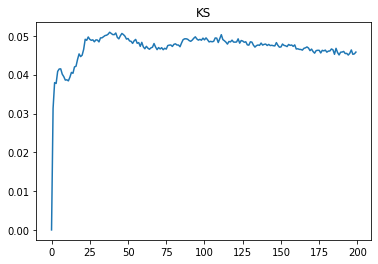

In [14]:
plt.plot(ks_list)
plt.title("KS")
plt.show()

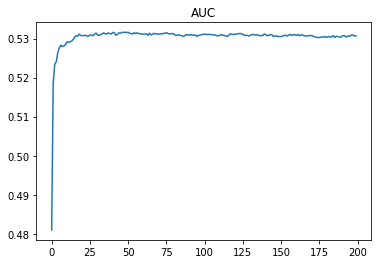

In [15]:
plt.plot(auc_list)
plt.title("AUC")
plt.show()